In [ ]:
import os
import sys
import numpy as np
import warnings
import librosa #for audio processing
import IPython. display as ipd
from keras.utils import np_utils
import matplotlib. pyplot as plt
from IPython.display import Audio
from scipy. io import wavfile #for audio processing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()
np.random.seed(1)

warnings. filterwarnings("ignore")

sample_r = 8000
bs = 32

snapshot_folder ='weights'

In [ ]:
!pip install librosa==0.8.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def progressBar(value, endvalue, bar_length=20,job='Job'):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_audio_path = '/content/drive/MyDrive/ColabNotebook/train/audio'
labels=os.listdir(train_audio_path)

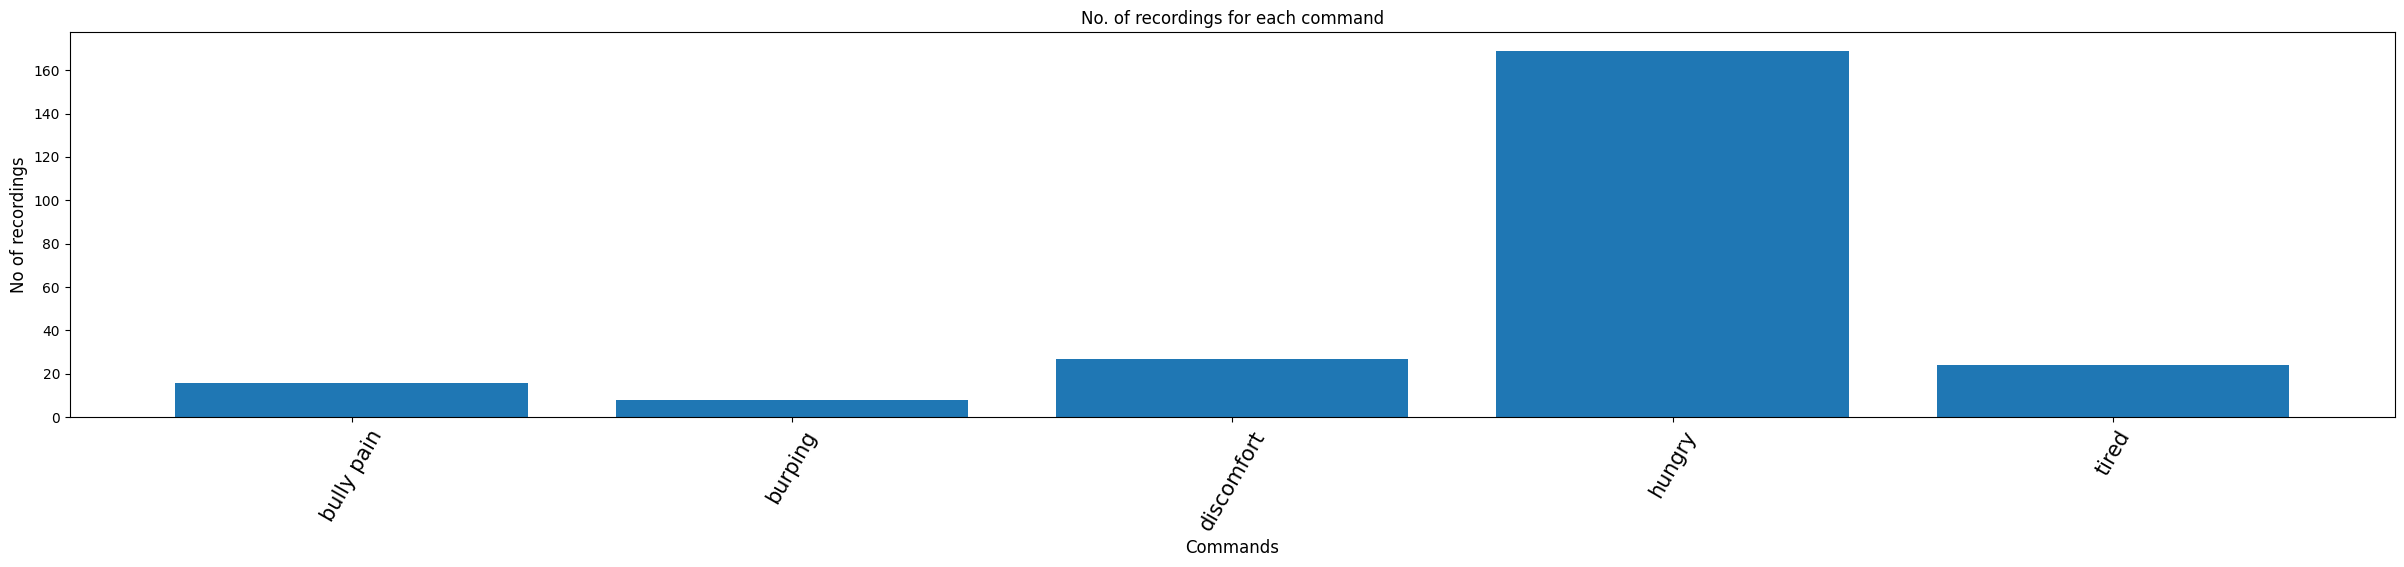

In [ ]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [ f for f in os. listdir(train_audio_path + '/' + label) if f. endswith('.wav' )]
    no_of_recordings. append(len(waves))

# ploting the class distribution
plt. figure(figsize=(30, 5))
index = np. arange(len(labels))
plt. bar(index, no_of_recordings)
plt. xlabel('Commands' , fontsize=12)
plt. ylabel('No of recordings' , fontsize=12)
plt. xticks(index, labels, fontsize=15, rotation=60)
plt. title('No. of recordings for each command' )
plt. show()
labels=[ "yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

(array([  4.,   3.,  18.,   2.,  12.,  11.,  12.,  49., 114.,  19.]),
 array([6.52 , 6.574, 6.628, 6.682, 6.736, 6.79 , 6.844, 6.898, 6.952,
        7.006, 7.06 ]),
 <BarContainer object of 10 artists>)

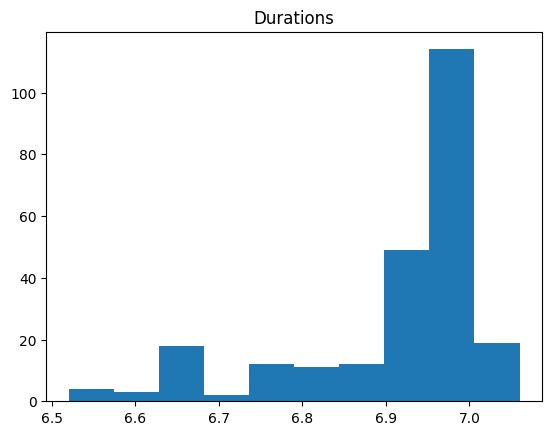

In [ ]:
train_audio_path = '/content/drive/MyDrive/ColabNotebook/train/audio'
labels=os. listdir(train_audio_path)     
duration_of_recordings=[]
for label in labels:
    waves = [ f for f in os. listdir(train_audio_path + '/' + label) if f. endswith('.wav' )]
    for wav in waves:
        sample_rate, samples = wavfile. read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples) /sample_rate))

len_train = len(duration_of_recordings)
plt.title('Durations')
plt.hist(np.array(duration_of_recordings))

In [ ]:
train_audio_path = '/content/drive/MyDrive/ColabNotebook/train/audio'
labels=os. listdir(train_audio_path)

def read_data(train_audio_path):
    i =0 
    all_wave = []
    all_label = []
    for label in labels:
        i+=1
        progressBar(i, len(labels), bar_length=20,job='Resampling, Removing shorter commands')
        waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
        for wav in waves:
            samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
            samples = librosa.core.resample(samples, sample_rate, sample_r )
            if(len(samples)== 56000) :
               all_wave.append(samples)
               all_label.append(label)
                
    return all_wave, all_label

all_wave, all_label = read_data(train_audio_path)
print(len(all_wave))

Resampling, Removing shorter commands Completion: [------------------->] 100%97


In [ ]:
sample_r= 56000

In [ ]:
train_audio_path ='/content/drive/MyDrive/ColabNotebook/train/audio'
labels=os. listdir(train_audio_path)
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
classes
len(y)

97

In [ ]:
y=np_utils.to_categorical(y, num_classes=len(labels))
len(y)

97

In [ ]:
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y, test_size = 0.2, random_state=1, shuffle=True)

In [ ]:
x_tr = np.array(x_tr).reshape(-1,sample_r,1)
x_val = np.array(x_val).reshape(-1,sample_r,1)

In [ ]:
def make_model():
    inputs = Input(shape=(sample_r,1))

    #First Conv1D layer
    conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Second Conv1D layer
    conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Third Conv1D layer
    conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Fourth Conv1D layer
    conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Flatten layer
    conv = Flatten()(conv)

    #Dense Layer 1
    conv = Dense(256, activation='relu')(conv)
    conv = Dropout(0.3)(conv)

    #Dense Layer 2
    conv = Dense(128, activation='relu')(conv)
    conv = Dropout(0.3)(conv)

    outputs = Dense(len(labels), activation='softmax')(conv)

    model = Model(inputs, outputs)
    model.summary()
    return model
    

In [ ]:
model = make_model()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 56000, 1)]        0         
                                                                 
 conv1d (Conv1D)             (None, 55988, 8)          112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18662, 8)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 18662, 8)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 18652, 16)         1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6217, 16)         0         
 1D)                                                         

In [ ]:
!mkdir model

In [ ]:
snapshot_folder='model'
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, min_delta=0.0001) 
mc = ModelCheckpoint(snapshot_folder+'/best_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
history= model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=bs, validation_data=(x_val,y_val))

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 1.8379 - accuracy: 0.3506
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to model/best_model.hdf5
3/3 [==============================] - 8s 2s/step - loss: 1.8379 - accuracy: 0.3506 - val_loss: 1.4689 - val_accuracy: 0.6000
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 1.4195 - accuracy: 0.5714
Epoch 2: val_accuracy did not improve from 0.60000
3/3 [==============================] - 6s 1s/step - loss: 1.4195 - accuracy: 0.5714 - val_loss: 1.5159 - val_accuracy: 0.6000
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 1.3367 - accuracy: 0.5584
Epoch 3: val_accuracy did not improve from 0.60000
3/3 [==============================] - 5s 1s/step - loss: 1.3367 - accuracy: 0.5584 - val_loss: 1.4771 - val_accuracy: 0.6000
Epoch 4/100
3/3 [==============================] - ETA: 0s - loss: 1.3059 - accuracy: 0.6104
Epoch 4: val_accuracy did not improve from 0.60000
3/3 [=

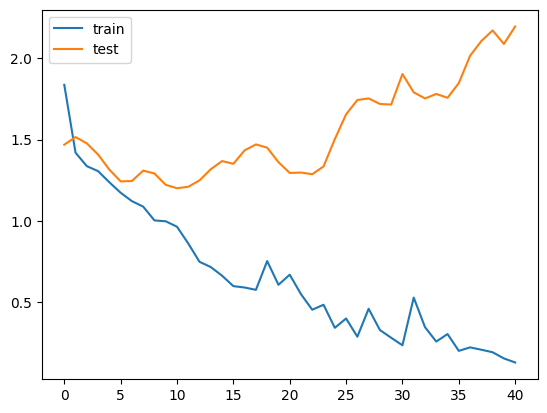

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [ ]:
from tensorflow import keras
def predict(audio):
    model=keras.models.load_model('/content/model/best_model.hdf5')
    prob=model.predict(audio.reshape(1,sample_r,1))
    index=np.argmax(prob[0])
    return classes[index]

In [ ]:
import random
index=random.randint(0,len(x_tr)-1)
samples=x_tr[index].ravel()
print("Audio:",classes[np.argmax(y_tr[index])])
ipd.Audio(samples, rate=sample_r)
print("Text:",predict(samples))

Audio: tired
1/1 [==============================] - 0s 146ms/step
Text: tired


In [ ]:
from tensorflow import keras
import tensorflow as tf
model = tf.keras.models.load_model('/content/model/best_model.hdf5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
   f.write(tflite_model)
